<a href="https://colab.research.google.com/github/AntoPrinzi99/NN-project-Antonino-Prinzivalli/blob/main/AE_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AE stitching:

##Importing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import datetime

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from tqdm import tqdm_notebook as tqdm
import pandas as pd

##Download data saet

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#latent_dims = 2
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # this will change the intervall of the image from 0,1  to -1,+1 , for this i use a tanh as activation function
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # i just want to see if there are any differents in the embedding for other reasons

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17530437.40it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479109.67it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4427604.33it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 13794734.81it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



##Selecting the Anchors

In [4]:
def get_class_anchors(dataset, num_classes=10):
    class_anchors = []
    class_count = {i: 0 for i in range(num_classes)}

    for data, target in dataset:
        if all(count > 0 for count in class_count.values()):
            break
        if class_count[target] == 0:
            class_anchors.append((data, target))
            class_count[target] += 1

    class_anchors.sort(key=lambda x: x[1])
    anchor_images = torch.stack([item[0] for item in class_anchors])
    return anchor_images

# Extract anchor images from the training dataset
anchors_images = get_class_anchors(train_dataset, num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
anchors_images = anchors_images.to(device)

# print to verify
print(anchors_images.shape)

torch.Size([10, 1, 28, 28])


##Defination of the relative model:

In [5]:
capacity = 64
latent_dims = 10
batch_size = 64
num_anchors = 10

class Encoder(nn.Module):
    def __init__(self, anchors):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.anchors = anchors
        self.fc_relative_to_latent = nn.Linear(num_anchors, latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)


        with torch.no_grad():
            anchors_embeddings = self.encode_anchors(self.anchors)

        relative_latent = self.relative_projection(x, anchors_embeddings)  #HERE I DO THE TRANSFORMATION


        return relative_latent

    def encode_anchors(self, anchors_images):
        with torch.no_grad():
            x = F.relu(self.conv1(anchors_images))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
            x = self.fc(x)
        return x

    def relative_projection(self, x, anchors):
        x = F.normalize(x, p=2, dim=-1)
        anchors = F.normalize(anchors, p=2, dim=-1)
        return torch.einsum("bm, am -> ba", x, anchors)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

class Autoencoder(nn.Module):
    def __init__(self, anchors):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(anchors)
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon


# Initialise autoencoder with the anchors
autoencoder = Autoencoder(anchors_images).to(device)

##Training

###First encoder:

In [6]:
# Initialising the trainer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for data in train_dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}')


num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Epoch [1/20], Loss: 0.24992148072989
Epoch [2/20], Loss: 0.15957333868754697
Epoch [3/20], Loss: 0.11259168462712628
Epoch [4/20], Loss: 0.09072511940241368
Epoch [5/20], Loss: 0.09095082169910992
Epoch [6/20], Loss: 0.09111354698631555
Epoch [7/20], Loss: 0.08227627093730959
Epoch [8/20], Loss: 0.07824238850427334
Epoch [9/20], Loss: 0.08085596737767588
Epoch [10/20], Loss: 0.07885890778130306
Epoch [11/20], Loss: 0.07637415344971837
Epoch [12/20], Loss: 0.07236596674267162
Epoch [13/20], Loss: 0.07476106646663344
Epoch [14/20], Loss: 0.07120202276815991
Epoch [15/20], Loss: 0.07074186892143444
Epoch [16/20], Loss: 0.0747761013808408
Epoch [17/20], Loss: 0.06991119754276295
Epoch [18/20], Loss: 0.07107415412471238
Epoch [19/20], Loss: 0.0709192810742967
Epoch [20/20], Loss: 0.06806820775590726
Number of parameters: 396281


###Second one:

In [7]:
# i define the second AE
autoencoder2 = Autoencoder(anchors_images).to(device)


optimizer = torch.optim.Adam(autoencoder2.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder2.train()
    running_loss = 0.0
    for data in train_dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        # Forward pass
        outputs = autoencoder2(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}')


num_params = sum(p.numel() for p in autoencoder2.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Epoch [1/20], Loss: 0.26264108587175544
Epoch [2/20], Loss: 0.15925293474563404
Epoch [3/20], Loss: 0.1118407830405337
Epoch [4/20], Loss: 0.09583097534266108
Epoch [5/20], Loss: 0.08713939806609265
Epoch [6/20], Loss: 0.0790936368138297
Epoch [7/20], Loss: 0.07417792542529766
Epoch [8/20], Loss: 0.07157326989304791
Epoch [9/20], Loss: 0.06904256768000405
Epoch [10/20], Loss: 0.06620643196552038
Epoch [11/20], Loss: 0.06408866376542588
Epoch [12/20], Loss: 0.06234153966183093
Epoch [13/20], Loss: 0.061252547026887885
Epoch [14/20], Loss: 0.059866629906300546
Epoch [15/20], Loss: 0.05935401247857985
Epoch [16/20], Loss: 0.05832773447036743
Epoch [17/20], Loss: 0.05777876816991804
Epoch [18/20], Loss: 0.0571382761335195
Epoch [19/20], Loss: 0.056523921059520005
Epoch [20/20], Loss: 0.05572670185044885
Number of parameters: 396281


##test of both encoders:

###First Encoder

Original images


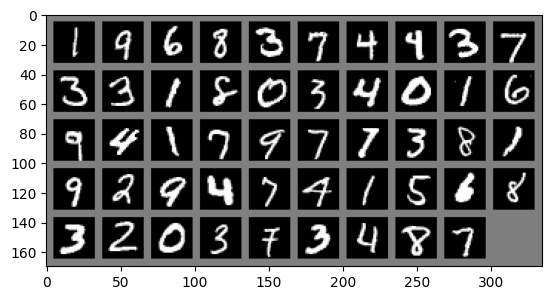

Autoencoder reconstruction:


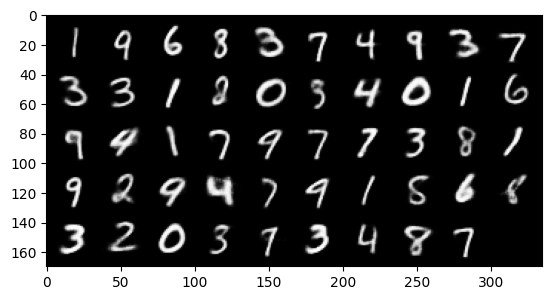

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

###Second Encoder

Original images


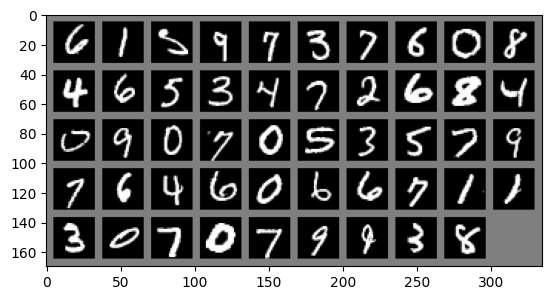

Autoencoder reconstruction:


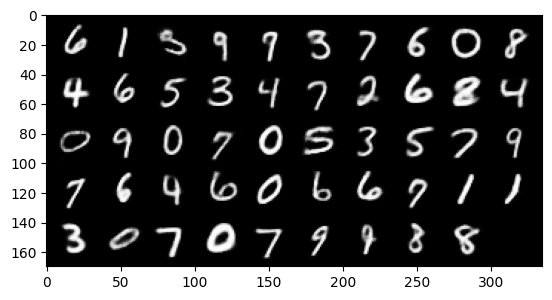

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder2.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder2)

##Now i do the stitch:

just save the models:

In [10]:
#torch.save(autoencoder.state_dict(), 'autoencoder_weights.pth')
#torch.save(autoencoder2.state_dict(), 'autoencoder2_weights.pth')

In [11]:
#autoencoder3=Autoencoder(anchors_images).to(device)
#autoencoder4=Autoencoder(anchors_images).to(device)
#autoencoder3.load_state_dict(torch.load('/content/autoencoder_weights.pth'))
#autoencoder4.load_state_dict(torch.load('/content/autoencoder2_weights.pth'))


In [12]:
class StitchedAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(StitchedAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent = self.encoder(x)
        print(f"latent shape: {latent.shape}")
        decoded = self.decoder(latent)
        print(f"decoded shape: {decoded.shape}")
        return decoded

In [13]:
# Ensure models are in evaluation mode
autoencoder.eval()
autoencoder2.eval()
stitched_autoencoder = StitchedAutoencoder(autoencoder.encoder, autoencoder2.decoder).to(device)

Original images


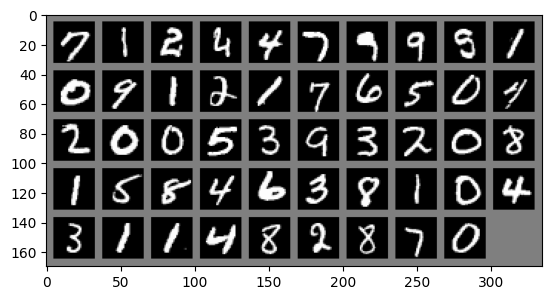

Autoencoder reconstruction:
latent shape: torch.Size([128, 10])
decoded shape: torch.Size([128, 1, 28, 28])


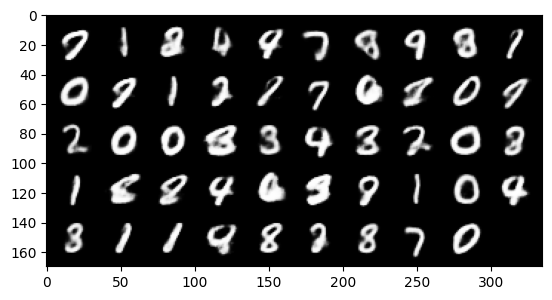

In [15]:
stitched_autoencoder.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50], 10, 5))
plt.show()

# Reconstruct and visualise the images using the stitched autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, stitched_autoencoder)